In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_csv('../input/nifty50-stock-market-data/ICICIBANK.csv')
df=df[['Date','Open']]
print(df.shape)
df.head()

(5163, 2)


,Date,Open
0,2000-01-03,74.35
1,2000-01-04,73.05
2,2000-01-05,70.00
3,2000-01-06,71.00
4,2000-01-07,69.00


# Make Date column as Index and dtype datetime 

In [3]:
df.index=pd.to_datetime(df['Date'])
df.drop('Date',axis=1,inplace=True)
df.head()

,Open
Date,
2000-01-03,74.35
2000-01-04,73.05
2000-01-05,70.00
2000-01-06,71.00
2000-01-07,69.00


# Plotting

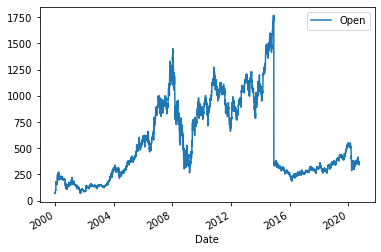

In [4]:
df.plot()

In [5]:
df['Open'].autocorr()

0.9974540063789649

From the Autocorrelation, we can say that todays prices is highly corelated with yesterday's price

# Take Past 6yr of Data

In [6]:
df=df[(df.index>='2015')]
print(df.shape)
df.head()

(1423, 1)


,Open
Date,
2015-01-01,352.7
2015-01-02,352.0
2015-01-05,365.3
2015-01-06,359.4
2015-01-07,345.6


0.9949799278571408


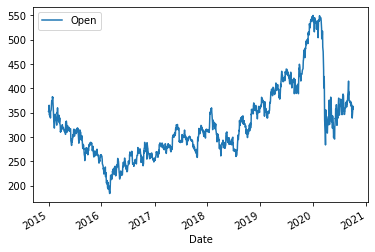

In [7]:
print(df['Open'].autocorr())
df.plot()

From the Autocorrelation, we can say that todays prices is highly corelated with yesterday's price

# AutoCorrelation of Past 5yr:

In [8]:
print(df[(df.index>='2015') & (df.index<'2015-12-31')]['Open'].autocorr())
print(df[(df.index>='2016') & (df.index<'2016-12-31')]['Open'].autocorr())

print(df[(df.index>='2017') & (df.index<'2017-12-31')]['Open'].autocorr())
print(df[(df.index>='2018') & (df.index<'2018-12-31')]['Open'].autocorr())
print(df[(df.index>='2019') & (df.index<'2019-12-31')]['Open'].autocorr())

0.9802250202638142
0.960836645084141
0.9586224461206558
0.9753657208535687
0.9896584236702162


# Analysing Data
1. Test for Random Walk (We can't forcast random walk )
2. If random walk make it stationary
3. Compute ACF and PACF (To determine order of AR or MA model)
4. Fit a few AR,MA and ARMA models
5. Use Information Criterion to select best model
6. Forcast Jan,2020 data using past 5yr of data 

## 1. Test the time series is stationary or not:
Test it using Dickey-Fuller test 

In [9]:
#H0: Null Hypothysis (It is not stationary)
#H1: Alternate Hypothysis (It is stationary)

def test_rw(df):
    result=adfuller(df)
    labels=['ADF Test Statistic','p-Value','Lag Used','No. of Observations']
    for val,label in zip(result,labels):
        print(label,end="=")
        print (val) 

    if(result[1]<=0.05):
        print("Reject the Null Hypothesis (H0) and it is stationary")
    else:
        print("We can't Reject the Null Hypothesis (H0) and it is not a stationary")
test_rw(df['Open'])        

ADF Test Statistic=-1.920589166089935
p-Value=0.32243816363896916
Lag Used=9
No. of Observations=1413
We can't Reject the Null Hypothesis (H0) and it is not a stationary


## 2. Make the stationary

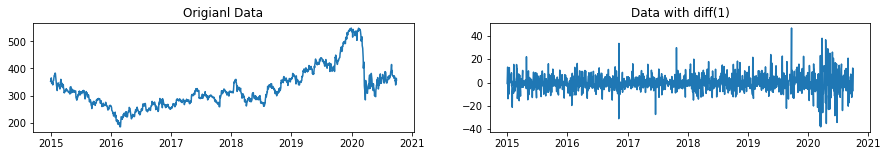

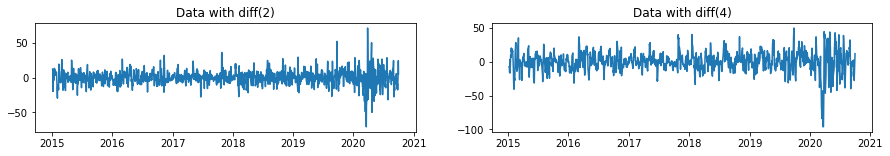

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(15,2))
ax1.plot(df['Open'])
ax1.set_title("Origianl Data")

ax2.plot(df['Open'].diff(1))
ax2.set_title("Data with diff(1)")

fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(15,2))

ax1.plot(df['Open'].diff(2))
ax1.set_title("Data with diff(2)")

ax2.plot(df['Open'].diff(4))
ax2.set_title("Data with diff(4)")


plt.show()

In [11]:
test_rw(df['Open'].diff(1).dropna())

ADF Test Statistic=-11.865329216036567
p-Value=6.696501365167337e-22
Lag Used=8
No. of Observations=1413
Reject the Null Hypothesis (H0) and it is stationary


In [12]:
# hence after 1st difference time series become stationary
for i in range(100,150):
    temp=df['Open'].diff(i).dropna()
    result=adfuller(temp)
    if(result[1]<=0.05):
        print("At diff({}) it is stationary = {}".format(i,temp.autocorr()))    


At diff(100) it is stationary = 0.9883917148082663
At diff(101) it is stationary = 0.9882622956321109
At diff(102) it is stationary = 0.9882740705146844
At diff(103) it is stationary = 0.9884693442853985
At diff(104) it is stationary = 0.9883261373446013
At diff(105) it is stationary = 0.9888410185515025
At diff(106) it is stationary = 0.9890384723308929
At diff(107) it is stationary = 0.9882314450086768
At diff(108) it is stationary = 0.9887577612853246
At diff(109) it is stationary = 0.9890089903045239
At diff(110) it is stationary = 0.9890110162308235
At diff(111) it is stationary = 0.9888844351306704
At diff(112) it is stationary = 0.9884979527010569
At diff(114) it is stationary = 0.9891726573285977
At diff(115) it is stationary = 0.9891061048726967
At diff(116) it is stationary = 0.9892339468683606
At diff(117) it is stationary = 0.9896429670497199
At diff(118) it is stationary = 0.9890639007829672
At diff(121) it is stationary = 0.9889103115895876
At diff(122) it is stationary =

In [13]:
df2=pd.DataFrame()
df2['Open']=df['Open'].diff(123).dropna()
df2.index = pd.to_datetime(df2.index, format='%Y')
df2.head()

,Open
2015-07-01,-44.00
2015-07-02,-37.70
2015-07-03,-53.55
2015-07-06,-50.30
2015-07-07,-31.60


## 3. Plot ACF and PACF to determine order of AR and MA
ACF is used to identify order of MA term, and PACF for AR. There is a thumb rule that for MA, the lag where ACF shuts off suddenly is the order of MA and similarly the lag where PACF shuts off suddenly is the order of AR

### 3.1 Identifying the order of AR model:

Figure(432x288)


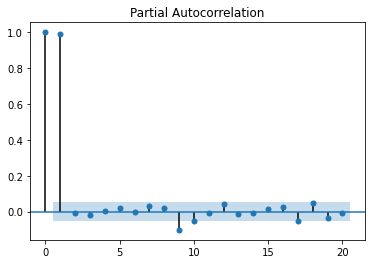

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf
print(plot_pacf(df2, lags= 20, alpha=0.05))

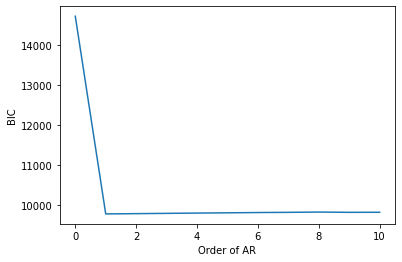

In [15]:
#lowest BIC hav
from statsmodels.tsa.arima_model import ARMA
bic_values=[]
for i in range(0,11):
    mod = ARMA(df2['Open'].values, order=(i,0))
    result = mod.fit()
    bic_values.append(result.bic)
    
plt.plot(bic_values)
plt.xlabel("Order of AR")
plt.ylabel("BIC")
plt.show()

From PACF plot and above grapg, order of AR model will be 1 i.e AR(1)

### 3.2 Identifying the order of MA model:

Figure(432x288)


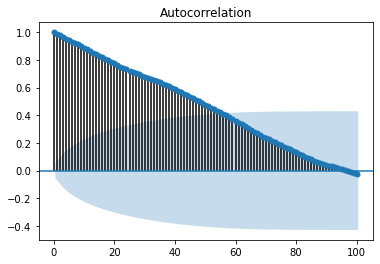

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
print(plot_acf(df2['Open'], lags= 100, alpha=0.05))

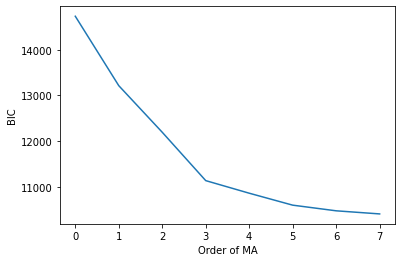

In [17]:
bic_values=[]
for i in range(0,10):
    try:
        mod = ARMA(df2['Open'].values, order=(0,i))
        result = mod.fit()
        bic_values.append(result.bic)
    except:
        pass

    
plt.plot(bic_values)
plt.xlabel("Order of MA")
plt.ylabel("BIC")
plt.show()

### 3.3 Identifying the order of ARMA model:

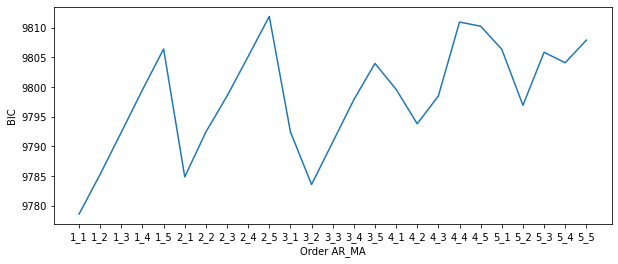

In [18]:
bic_values={}
for p in range(1,6):
    for q in range(1,6):
        try:
            mod = ARMA(df2['Open'].values, order=(p,q))
            result = mod.fit()            
            bic_values[str(p)+'_'+str(q)]=result.bic
        except:
            pass
plt.figure(figsize=(10,4))
plt.plot(list(bic_values.values()))
plt.xticks(list(range(len(bic_values.keys()))),list(bic_values.keys()))
plt.xlabel("Order AR_MA")
plt.ylabel("BIC")
plt.show()        

In [19]:
print(bic_values['1_1'])

9778.555211022296


# Models

In [20]:
df_train=df2[df2.index<'2020']
df_test=df2[(df2.index>='2020') & (df2.index<'2020-02-01')]

In [21]:
print(df_test.shape)
df_test

(23, 1)


,Open
2020-01-01,100.40
2020-01-02,97.00
2020-01-03,100.10
2020-01-06,99.25
2020-01-07,94.85
2020-01-08,82.00
2020-01-09,104.70
2020-01-10,114.90
2020-01-13,106.75
2020-01-14,108.90


In [22]:
print(df_train.shape)
print(df_train.shape[0])
df_train.head(20)

(1111, 1)
1111


,Open
2015-07-01,-44.00
2015-07-02,-37.70
2015-07-03,-53.55
2015-07-06,-50.30
2015-07-07,-31.60
2015-07-08,-36.60
2015-07-09,-42.95
2015-07-10,-30.25
2015-07-13,-34.50
2015-07-14,-22.25


## 1. AR Model (AR(1))

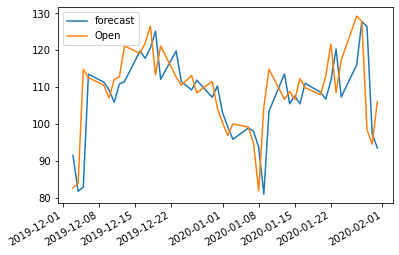

In [24]:
mod = ARMA(df2, order=(1,0))
res = mod.fit()

#2019-12-01 to 2020-01-31
res.plot_predict(start=df_train.shape[0]-20, end=df_train.shape[0]+df_test.shape[0]-1)
plt.show()

In [25]:
#2020-01-01 to 2020-01-31
y_pred=res.predict(start=df_train.shape[0], end=df_train.shape[0]+df_test.shape[0]-1)
y_true=df_test.values

print("MSE = ",mean_squared_error(y_true, y_pred))
print("RMSE = ",np.sqrt(mean_squared_error(y_true, y_pred)))

MSE =  107.282608555569
RMSE =  10.357731824852824


## 2. MA Model (MA(7))

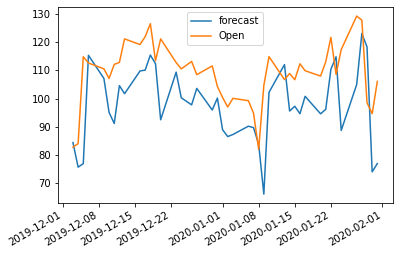

In [26]:
mod = ARMA(df2, order=(0,7))
res = mod.fit()

#2019-12-01 to 2020-01-31
res.plot_predict(start=df_train.shape[0]-20, end=df_train.shape[0]+df_test.shape[0]-1)
plt.show()

In [27]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   Open   No. Observations:                 1300
Model:                     ARMA(0, 7)   Log Likelihood               -5203.862
Method:                       css-mle   S.D. of innovations             13.231
Date:                Wed, 07 Oct 2020   AIC                          10425.724
Time:                        15:41:42   BIC                          10472.255
Sample:                             0   HQIC                         10443.183
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5588      3.477      0.736      0.462      -4.256       9.374
ma.L1.Open     1.3817      0.028     49.384      0.000       1.327       1.437
ma.L2.Open     1.6464      0.045     36.256      0.000       1.557       1.735
ma.L3.Open     1.6987      0.055     31.014      0.000       1.591       1.806
ma.L4.Open     1.5344      0.050     30.488      0.000       1.436       1.633
ma.L5.Open     1.2065      0.042     28.787      0.000       1.124       1.289
ma.L6.Open     0.7509      0.036     20.813      0.000       0.680       0.822
ma.L7.Open     0.2789      0.024     11.708      0.000       0.232       0.326
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            0.5341           -0.9460j            1.0864           -0.1682
MA.2            0.5341           +0.9460j            1.0864            0.1682
MA.3           -0.2241           -1.1588j            1.1802           -0.2804
MA.4           -0.2241           +1.1588j            1.1802            0.2804
MA.5           -0.9993           -0.8131j            1.2883           -0.3913
MA.6           -0.9993           +0.8131j            1.2883            0.3913
MA.7           -1.3142           -0.0000j            1.3142           -0.5000
-----------------------------------------------------------------------------
"""

In [28]:
#2020-01-01 to 2020-01-31
y_pred=res.predict(start=df_train.shape[0], end=df_train.shape[0]+df_test.shape[0]-1)
y_true=df_test.values

print("MSE = ",mean_squared_error(y_true, y_pred))
print("RMSE = ",np.sqrt(mean_squared_error(y_true, y_pred)))

MSE =  286.88656988925794
RMSE =  16.937726231382356


## 3. ARMA Model (ARMA(1,1))

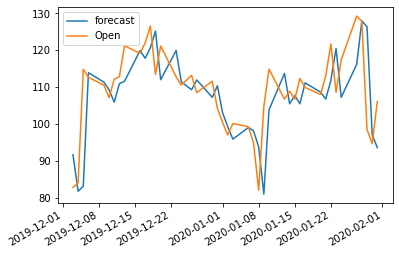

In [29]:
mod = ARMA(df2, order=(1,1))
res = mod.fit()
res.plot_predict(start=df_train.shape[0]-20, end=df_train.shape[0]+df_test.shape[0]-1)
plt.show()

In [30]:
#2020-01-01 to 2020-01-31
y_pred=res.predict(start=df_train.shape[0], end=df_train.shape[0]+df_test.shape[0]-1)
y_true=df_test.values

print("MSE = ",mean_squared_error(y_true, y_pred))
print("RMSE = ",np.sqrt(mean_squared_error(y_true, y_pred)))

MSE =  107.40619965940539
RMSE =  10.363696235388481
